In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

c:\Users\nolan\anaconda3\envs\sp25_taxi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-21 12:09:45,562 INFO: Initializing external client
2025-02-21 12:09:45,564 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-21 12:09:47,737 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212635


In [4]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1212635/featurestores/1200268/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [5]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (15.77s) 


In [6]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [7]:
ts_data.shape

(4544088, 3)

In [8]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4544088 entries, 0 to 4544087
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   pickup_hour         object
 1   pickup_location_id  int32 
 2   rides               int32 
dtypes: int32(2), object(1)
memory usage: 69.3+ MB


In [9]:
ts_data.describe()

,pickup_location_id,rides
count,4.544088e+06,4.544088e+06
mean,1.327500e+02,1.696554e+01
std,7.588710e+01,5.216986e+01
min,2.000000e+00,0.000000e+00
25%,6.700000e+01,0.000000e+00
50%,1.340000e+02,0.000000e+00
75%,1.990000e+02,2.000000e+00
max,2.630000e+02,1.089000e+03


In [10]:
ts_data['pickup_hour'].min()

'2023-01-01 00:00:00+00:00'

In [11]:
ts_data['pickup_hour'].max()

'2025-02-17 20:00:00+00:00'

In [12]:
ts_data_copy = ts_data.copy()

In [13]:
ts_data.tail()

,pickup_hour,pickup_location_id,rides
4544083,2025-02-17 16:00:00+00:00,263,70
4544084,2025-02-17 17:00:00+00:00,263,82
4544085,2025-02-17 18:00:00+00:00,263,102
4544086,2025-02-17 19:00:00+00:00,263,84
4544087,2025-02-17 20:00:00+00:00,263,71


In [14]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [15]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [16]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4544088 entries, 0 to 4544087
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 69.3 MB


In [17]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

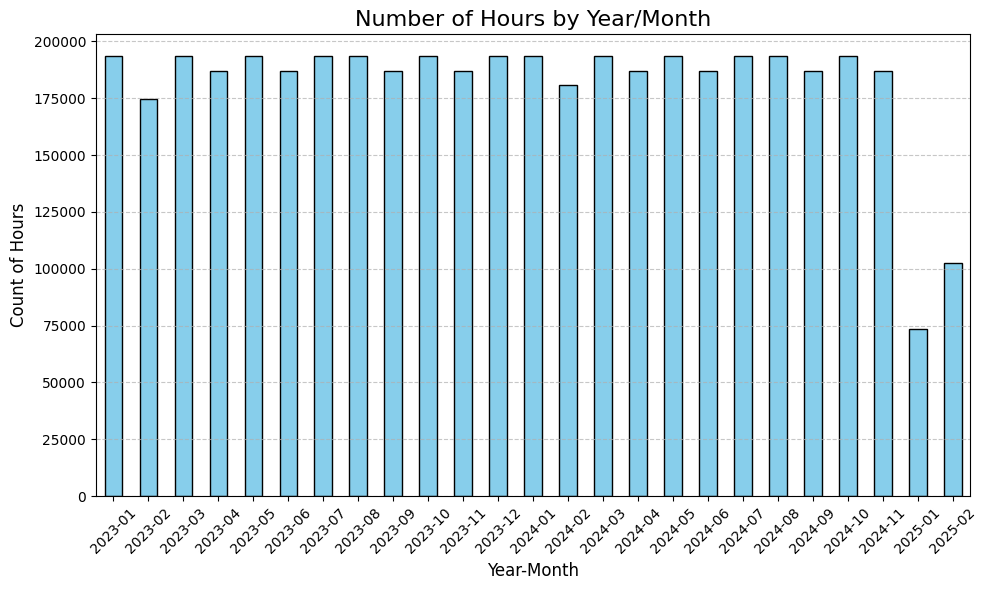

In [18]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [19]:
ts_data.head()

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [20]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [21]:
features.rename(columns={'location_id':'pickup_location_id'}, inplace=True)

In [22]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190105,151,154,127,88,84,65,51,54,40,28,...,72,132,173,147,127,117,121,123,2025-02-13 14:00:00,263
190106,111,85,90,87,96,62,68,50,21,18,...,27,55,130,125,131,119,121,123,2025-02-14 13:00:00,263
190107,99,91,81,80,94,78,80,60,50,32,...,19,19,31,37,56,81,90,113,2025-02-15 12:00:00,263
190108,106,96,92,98,107,132,97,82,91,71,...,35,14,12,29,39,42,65,106,2025-02-16 11:00:00,263


In [23]:
features_copy = features.copy()

In [24]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(190110, 675)

In [25]:
features_targets.head()

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id,target
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2023-01-29 00:00:00,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-29 23:00:00,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-30 22:00:00,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-31 21:00:00,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-02-01 20:00:00,2,0


In [26]:
from datetime import datetime, timedelta
import pandas as pd
from src.data_utils import split_time_series_data

# Define the cutoff date as 28 days before today
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=180))
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2024-08-25 12:15:07.505137')

In [27]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(156000, 674)
(156000,)
(34110, 674)
(34110,)


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156000 entries, 0 to 155999
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 801.6 MB


In [29]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [30]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.810795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 190110, number of used features: 675
[LightGBM] [Info] Start training from score 16.992846


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x0000028A7F9E0540>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [31]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [32]:
predictions

array([  0.17881526,   0.17881526,   0.17881526, ..., 131.41248108,
       125.15125149,  98.84540883])

In [33]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

2.3535


In [34]:
import joblib


# Save the pipeline
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\nolan\\cda500\\sp25_taxi\\models\\lgb_model.pkl']

In [35]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [36]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003

In [37]:
model.save('C:\\Users\\nolan\\cda500\\sp25_taxi\\models\\lgb_model.pkl')

Uploading: 100.000%|██████████| 318781/318781 elapsed<00:02 remaining<00:00  1.26it/s]
Uploading: 100.000%|██████████| 2049/2049 elapsed<00:02 remaining<00:000:07,  1.97s/it]
Uploading: 100.000%|██████████| 51418/51418 elapsed<00:02 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1212635/models/taxi_demand_predictor_next_hour/1


Model(name: 'taxi_demand_predictor_next_hour', version: 1)

In [39]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-02-21 12:19:36,452 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-02-21 12:19:36,506 INFO: Initializing external client
2025-02-21 12:19:36,512 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-21 12:19:37,623 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212635


In [40]:
from src.inference import get_model_predictions

preds = get_model_predictions(model, features_copy)

In [41]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
190105,263,117.0
190106,263,122.0
190107,263,131.0
190108,263,125.0


In [43]:
test_mae = mean_absolute_error(targets, preds['predicted_demand'])
print(f"{test_mae:.4f}")

2.2581
